In [1]:
!mkdir -p /home/gson/pytorch-book

In [2]:
%cd /home/gson/pytorch-book

/__modal/volumes/vo-09I0TEQIO3PwsMGBmy3EKx/pytorch-book


In [3]:
!ls

data_generation   model_checkpoint.pth	model_training
data_preparation  model_configuration	runs


In [4]:
import numpy as np
import datetime

import torch
import torch.optim as optim
import torch.nn as nn
import torch.functional as F

from torch.utils.data import Dataset, TensorDataset, DataLoader, random_split
from torch.utils.tensorboard import SummaryWriter

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('fivethirtyeight')

In [ ]:
class StepByStep:
    def __init__(self, model, loss_fn, optimizer):
        # Class config
        self.model = model
        self.loss_fn = loss_fn
        self.optimizer = optimizer
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.model.to(self.device)

        # Data Loaders
        self.train_loader = None
        self.val_loader = None

        # Summary Writer for Tensorboard
        self.writer = None

        # Training args
        self.losses = []
        self.val_losses = []
        self.total_epochs = 0

        # Training and Validation step functions
        self.train_step_fn = self._make_train_step_fn()
        self.val_step_fn = self._make_val_step_fn()

    def to(self, device):
        try:
            self.device = device
            self.model.to(self.device)
        except RuntimeError:
            self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
            print(f"Couldn't send it to {device}, sending it to {self.device} instead.")
            self.model.to(self.device)

    def set_loaders(self, train_loader, val_loader=None):
        self.train_loader = train_loader
        self.val_loader = val_loader

    def set_tensorboard(self, name, folder='runs'):
        suffix = datetime.datetime.now().strftime("%Y%m%d%H%M%S")
        self.writer = SummaryWriter(f"{folder}/{name}_{suffix}")

    def _make_train_step_fn(self):
        def perform_train_step_fn(x, y):
            self.model.train()
            y_pred = self.model(x)
            loss = self.loss_fn(y_pred, y)
    
            loss.backward()
            self.optimizer.step()
            self.optimizer.zero_grad()
            
            return loss.item()
    
        return perform_train_step_fn

    def _make_val_step_fn(self):
        def perform_val_step_fn(x, y):
            self.model.eval()
            y_pred = self.model(x)
            loss = self.loss_fn(y_pred, y)

            return loss.item()
        return perform_val_step_fn

    def _mini_batch(self, validation=False):
        if validation:
            data_loader = self.val_loader
            step_fn = self.val_step_fn
        else:
            data_loader = self.train_loader
            step_fn = self.train_step_fn

        if data_loader is None:
            return None

        mini_batch_losses = []
        for x_batch, y_batch in data_loader:
            x_batch = x_batch.to(self.device)
            y_batch = y_batch.to(self.device)

            mini_batch_loss = step_fn(x_batch, y_batch)
            mini_batch_losses.append(mini_batch_loss)

        loss = np.mean(mini_batch_losses)

        return loss

    def set_seed(self, seed=42):
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
        torch.manual_seed(seed)
        np.random.seed(seed)

    def train(self, n_epochs, seed=42):
        self.set_seed(seed)
        for epoch in range(n_epochs):
            self.total_epochs += 1
            loss = self._mini_batch(validation=False)
            self.losses.append(loss)

            with torch.no_grad():
                val_loss = self._mini_batch(validation=True)
                self.val_losses.append(val_loss)

            if self.writer:
                scalars = {'training': loss}
                if val_loss is not None:
                    scalars.update({'validation': val_loss})
                self.writer.add_scalars(main_tag='loss', tag_scalar_dict=scalars, global_step=epoch)

        if self.writer:
            self.writer.flush()

    def save_checkpoint(self, filename):
        checkpoint = {
            'epoch': self.total_epochs,
            'model_state_dict': self.model.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'loss': self.losses,
            'val_loss': self.val_losses
        }
        torch.save(checkpoint, filename)

    def load_checkpoint(self, filename):
        # Set weights_only=False, overriding the default value: True. 
        # We need to do this because we saved our checkpoint (model_checkpoint.pth) with more than just weights 
        # (We also saved losses, val_losses, epoch counters, etc.), and some of those objects involve numpy scalars.
        checkpoint = torch.load(filename, weights_only=False)  
        self.model.load_state_dict(checkpoint['model_state_dict'])
        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        self.total_epochs = checkpoint['epoch']
        self.losses = checkpoint['loss']
        self.val_losses = checkpoint['val_loss']
        self.model.train()

    def predict(self, x):
        self.model.eval()
        x_tensor = torch.as_tensor(x).float()
        y_pred_tensor = self.model(x_tensor.to(self.device))
        self.model.train()
        return y_pred_tensor.detach().cpu().numpy()

    def plot_losses(self):
        fig = plt.figure(figsize=(10, 4))
        plt.plot(self.losses, label='Training Loss', c='b')
        if self.val_loader:
            plt.plot(self.val_losses, label='Validation Loss', c='r')
        plt.yscale('log')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.tight_layout()
        return fig

    def add_graph(self):
        if self.train_loader and self.writer:
            x_dummy, y_dummy = next(iter(self.train_loader))
            self.writer.add_graph(self.model, x_dummy.to(self.device))

In [ ]:
# # ATTENTION! Using SETATTR for educational purposes only :-)
# setattr(StepByStep, '_make_train_step_fn', _make_train_step_fn)
# setattr(StepByStep, '_make_val_step_fn', _make_val_step_fn)

## Data Generation

In [7]:
!mkdir -p data_generation

In [ ]:
%%writefile data_generation/simple_linear_regression.py
import numpy as np

true_b = 1
true_w = 2
N = 100

# Data Generation
np.random.seed(42)
x = np.random.rand(N, 1)
epsilon = 0.1 * np.random.randn(N, 1)
y = true_b + true_w * x + epsilon

# Shuffles the indices
idx = np.arange(N)
np.random.shuffle(idx)

# Uses first 80 random indices for train
train_idx = idx[:int(N*.8)]
# Uses the remaining indices for validation
val_idx = idx[int(N*.8):]

# Generates train and validation sets
x_train, y_train = x[train_idx], y[train_idx]
x_val, y_val = x[val_idx], y[val_idx]

Overwriting data_generation/simple_linear_regression.py


## Run - Data Generation

In [ ]:
# Run data generation - so we don't need to copy code here
%run -i data_generation/simple_linear_regression.py

In [ ]:
true_w = 1
true_b = 2

N = 100

np.random.seed(42)
X = np.random.rand(N, 1)
epsillon = 0.1 * np.random.randn(N, 1)
Y = true_w * X + true_b + epsillon

In [11]:
# %load data_preparation/v2.py
torch.manual_seed(42)

x_tensor = torch.as_tensor(X).float()
y_tensor = torch.as_tensor(Y).float()

dataset = TensorDataset(x_tensor, y_tensor)

ratio = 0.8
n_total = len(dataset)
n_train = int(n_total * ratio)
n_val = n_total - n_train

train_data, val_data = random_split(dataset, [n_train, n_val])

train_loader = DataLoader(
    dataset=train_data,
    batch_size=16,
    shuffle=True
)
val_loader = DataLoader(dataset=val_data, batch_size=16)


## Model Configuration v4

In [ ]:
%%writefile model_configuration/v4.py
lr = 0.1

torch.manual_seed(42)
model = nn.Sequential(nn.Linear(1, 1))

optimizer = optim.SGD(model.parameters(), lr=lr)
loss_fn = nn.MSELoss()

Overwriting model_configuration/v4.py


In [13]:
%run -i model_configuration/v4.py

## Model Training

In [14]:
sbs = StepByStep(model, loss_fn, optimizer)
sbs.set_loaders(train_loader, val_loader)
sbs.set_tensorboard('classy')

In [15]:
# `sbs.model` is a view of `model` (It is not a copy!)
assert sbs.model == model
sbs.model.state_dict()

OrderedDict([('0.weight', tensor([[0.7645]], device='cuda:0')),
             ('0.bias', tensor([0.8300], device='cuda:0'))])

In [16]:
sbs.train(n_epochs=200)

In [17]:
sbs.model.state_dict()

OrderedDict([('0.weight', tensor([[0.9584]], device='cuda:0')),
             ('0.bias', tensor([2.0099], device='cuda:0'))])

In [ ]:
sbs.total_epochs

200

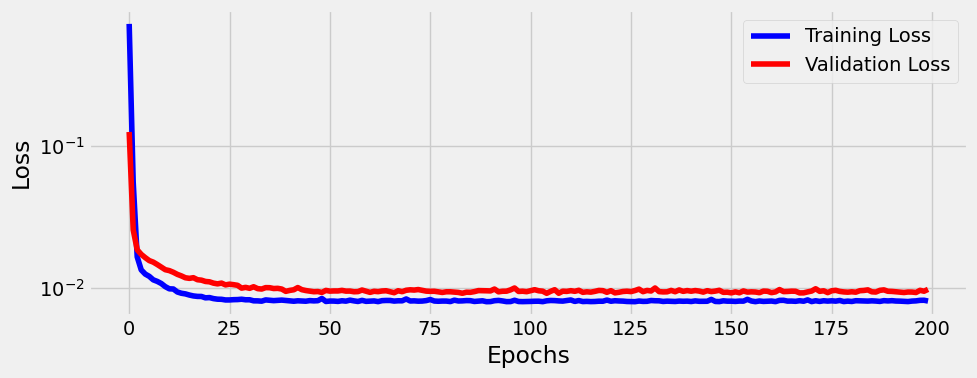

In [19]:
fig = sbs.plot_losses()

## Making New Predictions

In [20]:
new_data = np.array([0.5, 0.3, 0.7]).reshape(-1, 1)
new_data

array([[0.5],
       [0.3],
       [0.7]])

In [21]:
predictions = sbs.predict(new_data)
predictions

array([[2.4891284],
       [2.297444 ],
       [2.6808124]], dtype=float32)

## Checkpointing

In [22]:
sbs.save_checkpoint("model_checkpoint.pth")

## Resume Training

In [23]:
# Run Model Configuration
%run -i model_configuration/v4.py

<Figure size 640x480 with 0 Axes>

In [24]:
model.state_dict()

OrderedDict([('0.weight', tensor([[0.7645]])), ('0.bias', tensor([0.8300]))])

In [35]:
# Loading the trained model
new_sbs = StepByStep(model, loss_fn, optimizer)
new_sbs.load_checkpoint("model_checkpoint.pth")
model.state_dict()

OrderedDict([('0.weight', tensor([[0.9584]], device='cuda:0')),
             ('0.bias', tensor([2.0099], device='cuda:0'))])

In [ ]:
# 